In [1]:
from DSN import DeepSpectralNet
from Tool import fit
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
], dtype=np.float32)

# Labels XOR
y = np.array([
    0,
    1,
    1,
    0
], dtype=np.float32)
X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(y).unsqueeze(1)  # shape (4,1) pour la sortie

# Dataset et DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Vérification
for xb, yb in dataloader:
    print("Batch X:\n", xb)
    print("Batch y:\n", yb)

Batch X:
 tensor([[0., 1.],
        [1., 0.],
        [1., 1.],
        [0., 0.]])
Batch y:
 tensor([[1.],
        [1.],
        [0.],
        [0.]])


In [14]:
dsn = DeepSpectralNet([2,1])
dsn.num_parameters

9

In [ ]:
loss = nn.BCEWithLogitsLoss() 
model = fit(dsn,X_tensor,y_tensor,loss_function=loss)


Epoch 1/100 | Loss: 0.000000
Epoch 10/100 | Loss: 0.000000
Epoch 20/100 | Loss: 0.000000
Epoch 30/100 | Loss: 0.000000
Epoch 40/100 | Loss: 0.000000
Epoch 50/100 | Loss: 0.000000
Epoch 60/100 | Loss: 0.000000
Epoch 70/100 | Loss: 0.000000
Epoch 80/100 | Loss: 0.000000
Epoch 90/100 | Loss: 0.000000
Epoch 100/100 | Loss: 0.000000


In [36]:
head = dsn.layers[-1]
for name, param in head.named_parameters():
    print(f"{name} : {param.shape}")
print("U :", head.base_change.weight)
print("λ :", head.eigen_weights.weight)

base_change.weight : torch.Size([2, 2])
base_change.bias : torch.Size([2])
eigen_weights.weight : torch.Size([1, 2])
eigen_weights.bias : torch.Size([1])
U : Parameter containing:
tensor([[ 2.2050, -2.2050],
        [ 2.3401, -2.3401]], requires_grad=True)
λ : Parameter containing:
tensor([[3.1439, 3.5174]], requires_grad=True)


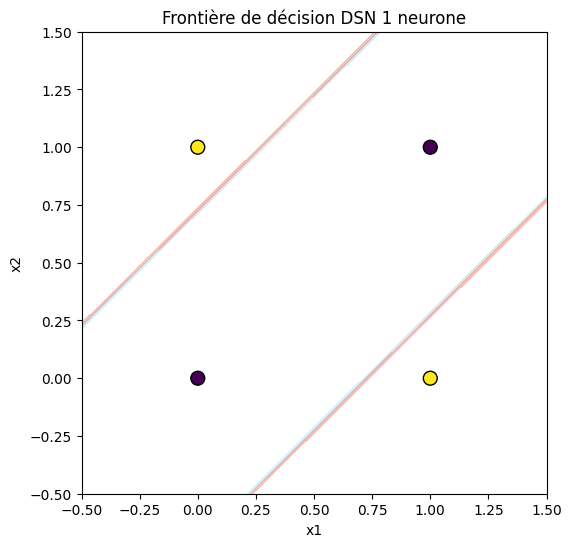

In [37]:
import matplotlib.pyplot as plt

# Création d'une grille
xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 200),
                     np.linspace(-0.5, 1.5, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# Calcul des sorties DSN sur la grille
dsn.eval()
with torch.no_grad():
    y_grid = dsn(grid_tensor).numpy()

# Reshape pour le contour
y_grid = y_grid.reshape(xx.shape)

# Plot
plt.figure(figsize=(6,6))
plt.contourf(xx, yy, y_grid, levels=[-0.1, 0.5, 1.1], colors=['lightblue','salmon'], alpha=0.5)
plt.scatter([0,0,1,1], [0,1,0,1], c=[0,1,1,0], edgecolor='k', s=100)
plt.title("Frontière de décision DSN 1 neurone")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


Entrées :
 [[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
Logits :
 [[-17.698353]
 [ 16.849262]
 [ 16.849258]
 [-17.698353]]
Probabilités :
 [[2.0592214e-08]
 [1.0000000e+00]
 [1.0000000e+00]
 [2.0592214e-08]]
Predicted labels :
 [[0.]
 [1.]
 [1.]
 [0.]]


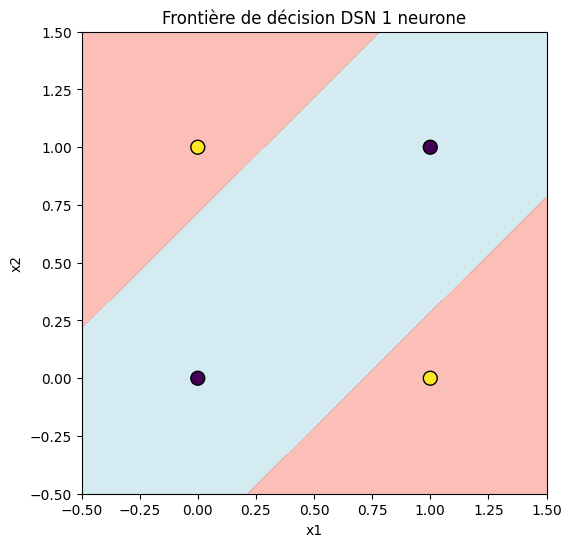

In [38]:
model.eval()
with torch.no_grad():
    logits = model(X_tensor)
    probs = torch.sigmoid(logits)
    predicted_labels = (probs > 0.5).float()
    print("\nEntrées :\n", X)
    print("Logits :\n", logits.numpy())
    print("Probabilités :\n", probs.numpy())
    print("Predicted labels :\n", predicted_labels.numpy())

# ---------------------
# Tracer la frontière de décision
# ---------------------
xx, yy = np.meshgrid(np.linspace(-0.5,1.5,200),
                     np.linspace(-0.5,1.5,200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

with torch.no_grad():
    Z = model(grid_tensor)
    Z = torch.sigmoid(Z).numpy().reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, Z, levels=[-0.1,0.5,1.1], colors=['lightblue','salmon'], alpha=0.5)
plt.scatter([0,0,1,1],[0,1,0,1], c=[0,1,1,0], edgecolor='k', s=100)
plt.title("Frontière de décision DSN 1 neurone")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [39]:
def print_polynomial_expression(model):
    # Récupération de la couche spectrale (supposée être la dernière ici)
    head = model.layers[-1] 
    
    # 1. Extraction des poids (détachés du graphe)
    # U : matrice de rotation (in_features x in_features)
    U = head.base_change.weight.detach()
    # b_u : biais interne avant le carré
    b_u = head.base_change.bias.detach() if head.base_change.bias is not None else torch.zeros(U.shape[0])
    
    # Lambda : poids des valeurs propres (out_features x in_features)
    # On prend la ligne 0 car on suppose une seule sortie (classification binaire ou régression 1D)
    lam = head.eigen_weights.weight.detach()[0] 
    # b_y : biais final
    b_y = head.eigen_weights.bias.detach()[0]
    
    # 2. Calcul des coefficients du polynôme développé
    # f(x) = A*x1^2 + B*x2^2 + C*x1*x2 + D*x1 + E*x2 + F
    
    # Coefficients quadratiques (x1^2 et x2^2)
    A = torch.sum(lam * (U[:, 0] ** 2)).item()
    B = torch.sum(lam * (U[:, 1] ** 2)).item()
    
    # Coefficient croisé (x1 * x2) -> vient du terme 2ab dans (a+b)^2
    C = torch.sum(lam * (2 * U[:, 0] * U[:, 1])).item()
    
    # Coefficients linéaires (x1 et x2) -> viennent du terme 2 * biais * poids
    D = torch.sum(lam * (2 * U[:, 0] * b_u)).item()
    E = torch.sum(lam * (2 * U[:, 1] * b_u)).item()
    
    # Constante finale -> somme des biais internes au carré pondérés + biais final
    F = (torch.sum(lam * (b_u ** 2)) + b_y).item()

    # 3. Affichage propre
    def fmt(val):
        return f"{val:+.4f}" # Format avec signe +/- et 4 décimales

    print("Expression du polynôme appris :")
    print("-" * 60)
    equation = (
        f"P(x) = {fmt(A)}*x1² "
        f"{fmt(C)}*x1*x2 "
        f"{fmt(B)}*x2² \n       "
        f"{fmt(D)}*x1 "
        f"{fmt(E)}*x2 "
        f"{fmt(F)}"
    )
    print(equation)
    print("-" * 60)
    
    return A, B, C, D, E, F

# Utilisation
coeffs = print_polynomial_expression(model)

Expression du polynôme appris :
------------------------------------------------------------
P(x) = +34.5476*x1² -69.0952*x1*x2 +34.5476*x2² 
       +0.0000*x1 -0.0000*x2 -17.6984
------------------------------------------------------------


In [40]:
def get_matrix_form(model):
    head = model.layers[-1] # On suppose que c'est la dernière couche
    
    # --- 1. Récupération des poids bruts ---
    # W : Matrice de changement de base (in x in)
    # Dans nn.Linear, les poids sont stockés en (out, in), donc W est bien la matrice de projection
    W = head.base_change.weight.detach() 
    
    # b : Biais de changement de base (in)
    b = head.base_change.bias.detach() if head.base_change.bias is not None else torch.zeros(W.shape[0])
    
    # Lambda : Les coefficients des valeurs propres (pour la 1ère sortie)
    # shape: (in_features,)
    lam = head.eigen_weights.weight.detach()[0]
    
    # b_out : Biais final
    b_out = head.eigen_weights.bias.detach()[0]

    # --- 2. Calcul des composants de l'équation f(x) = x^T Q x + L^T x + c ---
    
    # A. La Matrice Quadratique Q = W^T * diag(lambda) * W
    # Cela correspond à la somme pondérée des produits extérieurs des vecteurs de W
    diag_lambda = torch.diag(lam)
    Q = W.t() @ diag_lambda @ W
    
    # B. Le Vecteur Linéaire L = 2 * W^T * (lambda * b)
    # (lambda * b) est le produit élément par élément (Hadamard)
    L = 2 * W.t() @ (lam * b)
    
    # C. La Constante c = sum(lambda * b^2) + b_out
    c = torch.sum(lam * (b**2)) + b_out

    return Q, L, c

# --- Exécution ---
Q_mat, L_vec, constant = get_matrix_form(model)

print("Expression vectorielle : f(x) = x^T Q x + L^T x + c")
print("\nMatrice Q (Termes quadratiques) :\n", Q_mat)
print("\nVecteur L (Termes linéaires) :\n", L_vec)
print("\nConstante c :\n", constant.item())

# --- Vérification (Optionnelle) ---
# On prend un x au hasard pour vérifier que la formule matricielle donne le même résultat que le modèle
x_test = torch.randn(2) # vecteur colonne implicite
y_model = model(x_test.unsqueeze(0)).item()

# Calcul via la formule matricielle : xQx + Lx + c
y_formula = (x_test @ Q_mat @ x_test) + (L_vec @ x_test) + constant
print(f"\nVérification :\nModèle : {y_model:.6f}\nFormule: {y_formula.item():.6f}")

Expression vectorielle : f(x) = x^T Q x + L^T x + c

Matrice Q (Termes quadratiques) :
 tensor([[ 34.5476, -34.5476],
        [-34.5476,  34.5476]])

Vecteur L (Termes linéaires) :
 tensor([ 1.9624e-06, -1.9624e-06])

Constante c :
 -17.698352813720703

Vérification :
Modèle : 80.118057
Formule: 80.118057


In [ ]:
def get_exact_equation(model, decimals=4):
    """
    Extrait l'équation vectorielle exacte du DSN : f(x) = x^T Q x + L^T x + c
    Retourne les matrices numériques et la représentation sous forme de texte (string).
    """
    # Récupération de la dernière couche (là où la magie quadratique opère)
    head = model.layers[-1]
    
    # --- 1. Extraction des tenseurs (Poids & Biais) ---
    # W : Matrice de projection (shape: in_features x in_features)
    W = head.base_change.weight.detach()
    
    # b_in : Biais interne (shape: in_features)
    if head.base_change.bias is not None:
        b_in = head.base_change.bias.detach()
    else:
        b_in = torch.zeros(W.shape[0], device=W.device)
        
    # Lambda : Valeurs propres (shape: out_features x in_features)
    # On prend [0] car on suppose une sortie scalaire pour l'équation
    lam = head.eigen_weights.weight.detach()[0]
    
    # b_out : Biais final (scalaire)
    b_out = head.eigen_weights.bias.detach()[0]

    # --- 2. Calcul Algébrique des Matrices Q, L et c ---
    
    # A. Matrice Quadratique Q = W^T * diag(lambda) * W
    # C'est elle qui détermine la forme (ellipse, hyperbole...)
    diag_lambda = torch.diag(lam)
    Q = W.t() @ diag_lambda @ W
    
    # B. Vecteur Linéaire L = 2 * W^T * (lambda * b_in)
    # C'est lui qui déplace le centre de la forme
    # Note: (lam * b_in) est un produit terme à terme
    L = 2 * W.t() @ (lam * b_in)
    
    # C. Constante c = sum(lambda * b_in^2) + b_out
    c = torch.sum(lam * (b_in ** 2)) + b_out

    # --- 3. Formatage en String (Texte propre) ---
    
    # Fonction locale pour nettoyer l'affichage des matrices numpy
    def mat2str(tensor):
        arr = tensor.cpu().numpy()
        # Formatage style [[1.2, 0.5], [0.5, 3.1]]
        return np.array2string(arr, precision=decimals, separator=', ', suppress_small=True)

    def vec2str(tensor):
        arr = tensor.cpu().numpy()
        return np.array2string(arr, precision=decimals, separator=', ', suppress_small=True)

    # Création de la chaîne de l'équation
    equation_str = (
        f"f(x) = xᵀ · {mat2str(Q)} · x  "
        f"+  {vec2str(L)}ᵀ · x  "
        f"+  {c.item():.{decimals}f}"
    )

    return equation_str, Q, L, c

# ==========================================
# UTILISATION
# ==========================================

# 1. On récupère l'équation
eq_text, Q_matrix, L_vector, constant = get_exact_equation(model)

# 2. Affichage
print("=== Équation Vectorielle Apprise ===")
print(eq_text)
print("====================================")

def to_latex(Q, L, c):
    def t2l(tensor): 
        # Convertit un tenseur en syntaxe bmatrix LaTeX
        arr = tensor.cpu().numpy()
        if arr.ndim == 1: arr = arr.reshape(-1, 1) # Force vecteur colonne
        content = " \\\\\n".join([" & ".join([f"{x:.3f}" for x in row]) for row in arr])
        return f"\\begin{{pmatrix}}\n{content}\n\\end{{pmatrix}}"

    return f"f(x) = x^T {t2l(Q)} x + {t2l(L)}^T x + {c.item():.3f}"

print("\n--- Code LaTeX (copier-coller) ---")
print(to_latex(Q_matrix, L_vector, constant))

=== Équation Vectorielle Apprise ===
f(x) = xᵀ · [[ 34.5476, -34.5476],
 [-34.5476,  34.5476]] · x  +  [ 0., -0.]ᵀ · x  +  -17.6984

--- Code LaTeX (copier-coller) ---
f(x) = x^T \begin{pmatrix}
34.548 & -34.548 \\
-34.548 & 34.548
\end{pmatrix} x + \begin{pmatrix}
0.000 \\
-0.000
\end{pmatrix}^T x + -17.698


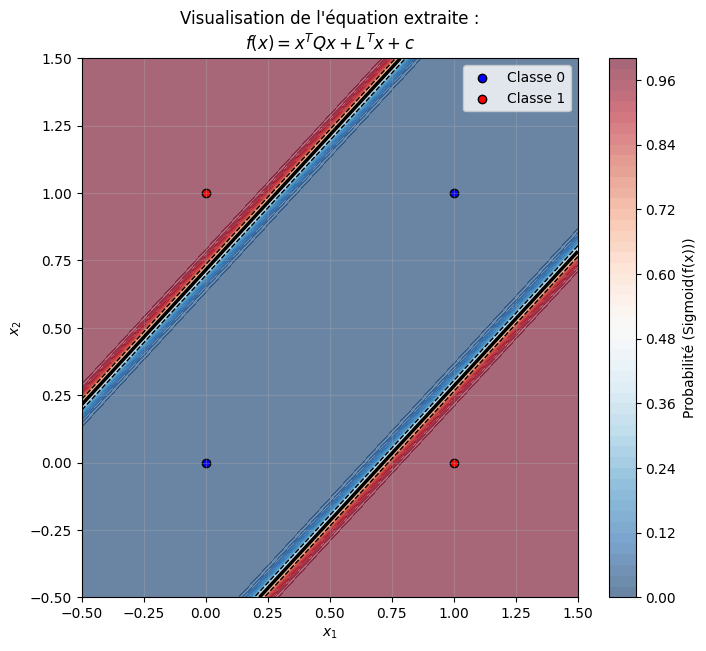

In [42]:
def plot_quadratic_equation(Q, L, c, X_data=None, y_data=None, resolution=200):
    """
    Trace la fonction f(x) = x^T Q x + L^T x + c
    
    Args:
        Q (torch.Tensor): Matrice quadratique (2x2)
        L (torch.Tensor): Vecteur linéaire (2)
        c (float): Constante
        X_data, y_data : Données d'entraînement pour superposition (optionnel)
    """
    # 1. Conversion Tensor -> Numpy pour l'affichage
    if torch.is_tensor(Q): Q = Q.detach().cpu().numpy()
    if torch.is_tensor(L): L = L.detach().cpu().numpy()
    if torch.is_tensor(c): c = c.item() if c.numel() == 1 else c.detach().cpu().numpy()
    
    # 2. Définition de la grille (limites basées sur les données ou par défaut)
    if X_data is not None:
        x_min, x_max = X_data[:, 0].min() - 0.5, X_data[:, 0].max() + 0.5
        y_min, y_max = X_data[:, 1].min() - 0.5, X_data[:, 1].max() + 0.5
    else:
        x_min, x_max, y_min, y_max = -1.5, 1.5, -1.5, 1.5

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))
    
    # On aplatit la grille pour le calcul vectoriel : shape (N, 2)
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # 3. CALCUL DE L'ÉQUATION : f(x) = x^T Q x + L^T x + c
    # Terme Quadratique : diag(x @ Q @ x.T) -> astuce vectorisée : sum((x @ Q) * x, axis=1)
    term_quad = np.sum((grid_points @ Q) * grid_points, axis=1)
    
    # Terme Linéaire : x @ L
    term_lin = grid_points @ L
    
    # Résultat total
    Z = term_quad + term_lin + c
    Z = Z.reshape(xx.shape)

    # 4. Affichage
    plt.figure(figsize=(8, 7))
    
    # Fond coloré (Carte de chaleur de l'énergie)
    # On applique une sigmoid pour simuler une probabilité 0-1 pour la couleur
    Z_prob = 1 / (1 + np.exp(-Z)) 
    contour = plt.contourf(xx, yy, Z_prob, levels=50, cmap='RdBu_r', alpha=0.6)
    plt.colorbar(contour, label="Probabilité (Sigmoid(f(x)))")

    # Lignes de niveau de l'équation pure f(x)
    # La ligne 0 est la frontière de décision
    plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2.5, linestyles='-')
    plt.contour(xx, yy, Z, levels=[-1, 1], colors='black', linewidths=1, linestyles='--')

    # Superposition des données réelles
    if X_data is not None and y_data is not None:
        if torch.is_tensor(X_data): X_data = X_data.cpu().numpy()
        if torch.is_tensor(y_data): y_data = y_data.cpu().numpy().flatten()
        
        plt.scatter(X_data[y_data==0, 0], X_data[y_data==0, 1], c='blue', edgecolors='k', label='Classe 0')
        plt.scatter(X_data[y_data==1, 0], X_data[y_data==1, 1], c='red', edgecolors='k', label='Classe 1')
        plt.legend()

    plt.title(f"Visualisation de l'équation extraite :\n$f(x) = x^T Q x + L^T x + c$")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.grid(True, alpha=0.3)
    plt.show()

# ==========================================
# UTILISATION
# ==========================================
# Assurez-vous d'avoir exécuté l'étape précédente pour avoir Q_matrix, L_vector, constant
# Et d'avoir vos données X, y accessibles

plot_quadratic_equation(Q_matrix, L_vector, constant, X, y)

In [43]:
import plotly.graph_objects as go
import numpy as np
import torch

def plot_interactive_surface(Q, L, c, X_data=None, y_data=None):
    """
    Crée un graphique 3D interactif avec Plotly.
    Q, L, c : Les paramètres de l'équation extraite f(x) = xTQx + LTx + c
    """
    # 1. Conversion Tensor -> Numpy
    if torch.is_tensor(Q): Q = Q.detach().cpu().numpy()
    if torch.is_tensor(L): L = L.detach().cpu().numpy()
    if torch.is_tensor(c): c = c.item() if c.numel() == 1 else c.detach().cpu().numpy()
    if X_data is not None and torch.is_tensor(X_data): X_data = X_data.cpu().numpy()
    if y_data is not None and torch.is_tensor(y_data): y_data = y_data.cpu().numpy().flatten()

    # 2. Création de la grille
    if X_data is not None:
        margin = 0.5
        x_min, x_max = X_data[:, 0].min() - margin, X_data[:, 0].max() + margin
        y_min, y_max = X_data[:, 1].min() - margin, X_data[:, 1].max() + margin
    else:
        x_min, x_max, y_min, y_max = -1.5, 1.5, -1.5, 1.5

    resolution = 50
    x_range = np.linspace(x_min, x_max, resolution)
    y_range = np.linspace(y_min, y_max, resolution)
    xx, yy = np.meshgrid(x_range, y_range)

    # 3. Calcul de Z (vectorisé)
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # f(x) = x^T Q x + L^T x + c
    term_quad = np.sum((grid_points @ Q) * grid_points, axis=1)
    term_lin = grid_points @ L
    Z = term_quad + term_lin + c
    Z = Z.reshape(xx.shape)

    # --- CONSTRUCTION DU GRAPHIQUE ---
    fig = go.Figure()

    # A. La Surface (La fonction apprise)
    fig.add_trace(go.Surface(
        x=x_range, y=y_range, z=Z,
        colorscale='Viridis',
        opacity=0.8,
        name='Surface f(x)',
        colorbar=dict(title='f(x)')
    ))

    # B. Le Plan de Décision (z=0)
    # On ajoute un plan transparent à z=0 pour voir la frontière
    zero_plane = np.zeros_like(Z)
    fig.add_trace(go.Surface(
        x=x_range, y=y_range, z=zero_plane,
        colorscale='Gray',
        showscale=False,
        opacity=0.3,
        name='Frontière (z=0)'
    ))

    # C. Les Points de Données (Scatter 3D)
    if X_data is not None and y_data is not None:
        # On projette les points sur la surface calculée pour voir s'ils "collent"
        pred_quad = np.sum((X_data @ Q) * X_data, axis=1)
        pred_lin = X_data @ L
        z_points = pred_quad + pred_lin + c
        
        # Classe 0 (Bleu)
        mask0 = (y_data == 0)
        fig.add_trace(go.Scatter3d(
            x=X_data[mask0, 0], y=X_data[mask0, 1], z=z_points[mask0],
            mode='markers',
            marker=dict(size=6, color='blue', symbol='circle', line=dict(color='white', width=1)),
            name='Classe 0'
        ))

        # Classe 1 (Rouge)
        mask1 = (y_data == 1)
        fig.add_trace(go.Scatter3d(
            x=X_data[mask1, 0], y=X_data[mask1, 1], z=z_points[mask1],
            mode='markers',
            marker=dict(size=6, color='red', symbol='diamond', line=dict(color='white', width=1)),
            name='Classe 1'
        ))

    # D. Mise en page
    fig.update_layout(
        title=f"Visualisation Interactive DSN<br>f(x) = xᵀQx + Lᵀx + c",
        scene=dict(
            xaxis_title='x1',
            yaxis_title='x2',
            zaxis_title='f(x) (Logits)',
            aspectmode='cube'
        ),
        width=900,
        height=700,
        margin=dict(l=0, r=0, b=0, t=50)
    )

    fig.show()

# --- UTILISATION ---
# Supposant que vous avez déjà extrait Q_matrix, L_vector, constant, X, y
plot_interactive_surface(Q_matrix, L_vector, constant, X, y)

In [155]:

torch.manual_seed(42)

# Nombre d'échantillons
N = 150000

# Variables physiques
m = torch.rand(N, 1) * 99.5 + 0.5   # masse ∈ [0.5, 10]
v = torch.rand(N, 1) * 200.0        # vitesse ∈ [0, 20]

# Energie vraie
E = 0.5 * m * v**2

# Bruit relatif (5%)
#E = E + 0.05 * E * torch.randn_like(E)

# Dataset final
X = torch.cat([m, v], dim=1)  # shape (N, 2)
y = E                         # shape (N, 1)

print(X.shape, y.shape)

torch.Size([150000, 2]) torch.Size([150000, 1])


In [161]:
dsn = DeepSpectralNet([2,20,1])
dsn.num_parameters
model = fit(dsn,X,y,epochs=3500,lr=0.001)

Epoch 1/3500 | Loss: 269779435520.000000
Epoch 10/3500 | Loss: 268620824576.000000
Epoch 20/3500 | Loss: 257250066432.000000
Epoch 30/3500 | Loss: 197010669568.000000
Epoch 40/3500 | Loss: 41063874560.000000
Epoch 50/3500 | Loss: 34226128896.000000
Epoch 60/3500 | Loss: 30924146688.000000
Epoch 70/3500 | Loss: 21964021760.000000
Epoch 80/3500 | Loss: 18163560448.000000
Epoch 90/3500 | Loss: 15796743168.000000
Epoch 100/3500 | Loss: 13775960064.000000
Epoch 110/3500 | Loss: 12033897472.000000
Epoch 120/3500 | Loss: 10583320576.000000
Epoch 130/3500 | Loss: 9377810432.000000
Epoch 140/3500 | Loss: 8376997376.000000
Epoch 150/3500 | Loss: 7548557312.000000
Epoch 160/3500 | Loss: 6868619776.000000
Epoch 170/3500 | Loss: 6317382144.000000
Epoch 180/3500 | Loss: 5877500928.000000
Epoch 190/3500 | Loss: 5533010944.000000
Epoch 200/3500 | Loss: 5268951552.000000
Epoch 210/3500 | Loss: 5071237632.000000
Epoch 220/3500 | Loss: 4926877696.000000
Epoch 230/3500 | Loss: 4824187904.000000
Epoch 240/

In [159]:
model = fit(dsn,X,y,epochs=1000)

Epoch 1/1000 | Loss: 252148016.000000
Epoch 10/1000 | Loss: 61186117632.000000
Epoch 20/1000 | Loss: 2703723520.000000
Epoch 30/1000 | Loss: 1801975168.000000
Epoch 40/1000 | Loss: 3975010560.000000
Epoch 50/1000 | Loss: 611088192.000000
Epoch 60/1000 | Loss: 928913280.000000
Epoch 70/1000 | Loss: 486418592.000000
Epoch 80/1000 | Loss: 514039232.000000
Epoch 90/1000 | Loss: 451656864.000000
Epoch 100/1000 | Loss: 414274720.000000
Epoch 110/1000 | Loss: 391995296.000000
Epoch 120/1000 | Loss: 371871424.000000
Epoch 130/1000 | Loss: 354328160.000000
Epoch 140/1000 | Loss: 339805440.000000
Epoch 150/1000 | Loss: 328117440.000000
Epoch 160/1000 | Loss: 318909536.000000
Epoch 170/1000 | Loss: 311723616.000000
Epoch 180/1000 | Loss: 306100544.000000
Epoch 190/1000 | Loss: 301622240.000000
Epoch 200/1000 | Loss: 297949696.000000
Epoch 210/1000 | Loss: 294825696.000000
Epoch 220/1000 | Loss: 292079424.000000
Epoch 230/1000 | Loss: 289598176.000000
Epoch 240/1000 | Loss: 287312384.000000
Epoch 

In [162]:
import sympy

def get_deep_equation(model, input_dim=2, precision=3):
    """
    Extrait l'équation polynomiale exacte d'un DSN profond (K couches).
    Retourne l'expression symbolique SymPy.
    """
    # 1. Création des variables symboliques (x_1, x_2, ...)
    # Ce sont des "inconnues" mathématiques, pas des nombres
    x_sym = [sympy.symbols(f'x_{i+1}') for i in range(input_dim)]
    
    # On initialise l'expression courante avec l'entrée
    current_expr = x_sym
    
    # 2. Propagation couche par couche (Forward Pass Symbolique)
    print(f"Extraction de l'équation pour {len(model.layers)} couches...")
    
    for i, layer in enumerate(model.layers):
        
        # --- Cas A : Couche Spectrale (Quadratique) ---
        if hasattr(layer, 'base_change') and hasattr(layer, 'eigen_weights'):
            # Extraction des poids numpy
            W_base = layer.base_change.weight.detach().cpu().numpy() # (in, in)
            b_base = layer.base_change.bias.detach().cpu().numpy() if layer.base_change.bias is not None else np.zeros(W_base.shape[0])
            
            W_eigen = layer.eigen_weights.weight.detach().cpu().numpy() # (out, in)
            b_eigen = layer.eigen_weights.bias.detach().cpu().numpy()   # (out,)
            
            # Étape 1 : Changement de base (Linéaire) -> h = Wx + b
            h_list = []
            for Row_idx in range(W_base.shape[0]):
                # Produit scalaire symbolique : somme(w_ij * x_j) + b_i
                val = sum(W_base[Row_idx, k] * current_expr[k] for k in range(len(current_expr))) + b_base[Row_idx]
                h_list.append(val)
            
            # Étape 2 : Mise au carré (Activation) -> energy = h^2
            energy_list = [h**2 for h in h_list]
            
            # Étape 3 : Combinaison (Valeurs Propres) -> y = Lambda * energy + b
            next_expr = []
            for Row_idx in range(W_eigen.shape[0]):
                val = sum(W_eigen[Row_idx, k] * energy_list[k] for k in range(len(energy_list))) + b_eigen[Row_idx]
                next_expr.append(val)
            
            current_expr = next_expr

        # --- Cas B : Couche Linéaire Classique (si présente) ---
        elif isinstance(layer, nn.Linear):
            W = layer.weight.detach().cpu().numpy()
            b = layer.bias.detach().cpu().numpy() if layer.bias is not None else np.zeros(W.shape[0])
            
            next_expr = []
            for Row_idx in range(W.shape[0]):
                val = sum(W[Row_idx, k] * current_expr[k] for k in range(len(current_expr))) + b[Row_idx]
                next_expr.append(val)
            current_expr = next_expr
            
        # --- Cas C : LayerNorm (Attention !) ---
        elif isinstance(layer, nn.LayerNorm):
            # LayerNorm brise la structure polynomiale (division par racine carrée).
            # Pour l'extraction d'équation, on l'ignore souvent ou on la traite comme identité 
            # si on veut juste voir la "forme" polynomiale brute.
            print(f"   Note: LayerNorm à la couche {i} ignorée pour simplification polynomiale.")
            pass

    # 3. Résultat Final
    # On suppose une seule sortie pour l'affichage (réseau de classification binaire / régression)
    final_poly = current_expr[0]
    
    # On demande à SymPy de développer et simplifier l'expression (x^2 + 2x + ...)
    expanded_poly = sympy.expand(final_poly)
    
    # Fonction pour arrondir les coefficients (sinon on a 0.0000000123*x)
    def round_expr(expr, num_digits):
        return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(sympy.Number)})

    rounded_poly = round_expr(expanded_poly, precision)
    
    return rounded_poly

# ================= EXEMPLE D'UTILISATION =================
equation = get_deep_equation(model, input_dim=2)
print("\nEquation du Réseau Profond :")
print(f"f(x) = {equation}")

Extraction de l'équation pour 2 couches...

Equation du Réseau Profond :
f(x) = 0.001*x_1**3*x_2 + 0.003*x_1**3 + 0.002*x_1**2*x_2**2 + 0.018*x_1**2*x_2 + 0.293*x_1**2 + 0.001*x_1*x_2**3 + 0.036*x_1*x_2**2 + 1.18*x_1*x_2 + 4.406*x_1 + 0.029*x_2**3 + 1.284*x_2**2 + 6.966*x_2 + 82.491


In [170]:
def get_clean_polynomial(model, input_dim=2, decimals=3):
    """
    Extrait, simplifie et nettoie l'équation polynomiale d'un DSN.
    """
    # 1. Définition des variables symboliques (x1, x2, ...)
    # real=True permet à SymPy de mieux simplifier certaines expressions
    x_vars = [sympy.symbols(f'x_{i+1}', real=True) for i in range(input_dim)]
    
    # On commence avec le vecteur d'entrée x
    current_expr = x_vars
    
    # 2. Propagation Symbolique à travers les couches
    print(f"--- Propagation symbolique sur {len(model.layers)} couches ---")
    
    for i, layer in enumerate(model.layers):
        # A. Couche Spectrale (Quadratique)
        if hasattr(layer, 'base_change'):
            print(f"Couche {i+1}: SpectralQuadratic (Degré x2)")
            
            # Récupération des poids (Numpy)
            W = layer.base_change.weight.detach().cpu().numpy()
            b = layer.base_change.bias.detach().cpu().numpy() if layer.base_change.bias is not None else np.zeros(W.shape[0])
            
            lam = layer.eigen_weights.weight.detach().cpu().numpy()
            beta = layer.eigen_weights.bias.detach().cpu().numpy()
            
            # -- Étape 1 : Projection Linéaire (h = Wx + b) --
            h = []
            for row in range(W.shape[0]):
                # Produit scalaire symbolique
                val = sum(W[row, k] * current_expr[k] for k in range(len(current_expr))) + b[row]
                h.append(val)
                
            # -- Étape 2 : Activation Quadratique (h^2) --
            h_sq = [term**2 for term in h]
            
            # -- Étape 3 : Combinaison Linéaire (y = Lambda * h^2 + beta) --
            next_expr = []
            for row in range(lam.shape[0]):
                val = sum(lam[row, k] * h_sq[k] for k in range(len(h_sq))) + beta[row]
                next_expr.append(val)
            
            current_expr = next_expr

        # B. Couche Linéaire Standard (si présente)
        elif isinstance(layer, nn.Linear):
            print(f"Couche {i+1}: Linear (Projection)")
            W = layer.weight.detach().cpu().numpy()
            b = layer.bias.detach().cpu().numpy() if layer.bias is not None else np.zeros(W.shape[0])
            
            next_expr = []
            for row in range(W.shape[0]):
                val = sum(W[row, k] * current_expr[k] for k in range(len(current_expr))) + b[row]
                next_expr.append(val)
            current_expr = next_expr
            
        # C. Normalisation (Ignorée pour garder le polynôme pur)
        elif isinstance(layer, nn.LayerNorm):
            pass

    # 3. Simplification et Nettoyage
    print("--- Simplification en cours (Expand)... ---")
    
    # On prend la première sortie (si classification binaire)
    raw_poly = current_expr[0]
    
    # A. DÉVELOPPEMENT : Transforme ((x+1)^2 + x)^2 en x^4 + ...
    expanded_poly = sympy.expand(raw_poly)
    
    # B. NETTOYAGE : Arrondir les coefficients flottants
    # SymPy garde souvent des trucs moches genre 0.999999998*x1**2
    # Cette astuce parcourt l'arbre de l'expression pour arrondir les nombres
    cleaned_poly = expanded_poly.xreplace({
        n: round(n, decimals) for n in expanded_poly.atoms(sympy.Number)
    })
    
    # Optionnel : Supprimer les termes très petits (proches de 0)
    # On reconstruit l'expression en gardant seulement les termes > 10^-decimals
    final_terms = []
    if isinstance(cleaned_poly, sympy.Add):
        for term in cleaned_poly.args:
            coef = term.as_coeff_Mul()[0] # Extrait le coefficient numérique
            if abs(coef) > 10**-(decimals+1):
                final_terms.append(term)
        final_poly = sum(final_terms)
    else:
        final_poly = cleaned_poly

    return final_poly

# ==========================================
# TEST : Voyons ce que ça donne
# ==========================================

# 1. Exemple : Un DSN avec 2 couches (Degré théorique = 4)
# Couche 1 : 2 inputs -> 3 neurones cachés
# Couche 2 : 3 inputs -> 1 output

# On extrait l'équation
equation = get_clean_polynomial(model, input_dim=2, decimals=2)

print("\nRESULTAT FINAL (Polynôme Développé) :")
print("-" * 60)
print(f"f(x1, x2) = {equation}")
print("-" * 60)

# Pour rendre ça joli en LaTeX dans un notebook :
sympy.init_printing()
display(equation)

--- Propagation symbolique sur 2 couches ---
Couche 1: SpectralQuadratic (Degré x2)
Couche 2: SpectralQuadratic (Degré x2)
--- Simplification en cours (Expand)... ---

RESULTAT FINAL (Polynôme Développé) :
------------------------------------------------------------
f(x1, x2) = -0.e-2*x_1**3*x_2 + 0.01*x_1**3 + 0.01*x_1**2*x_2**2 - 0.04*x_1**2*x_2 - 0.82*x_1**2 + 0.01*x_1*x_2**2 + 5.65*x_1*x_2 - 8.06*x_1 - 0.57*x_2**2 + 0.13*x_2 + 4.01
------------------------------------------------------------


In [183]:
import torch
import torch.nn as nn
import torch.optim as optim
import sympy
import numpy as np

# --- 1. Modèle (20 neurones comme validé) ---
class SpectralQuadraticLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.base_change = nn.Linear(in_features, in_features, bias=bias)
        self.eigen_weights = nn.Linear(in_features, out_features, bias=True)
        # Init un peu plus large pour encourager la diversité
        nn.init.xavier_uniform_(self.base_change.weight, gain=1.5)
        nn.init.xavier_uniform_(self.eigen_weights.weight, gain=1.5)

    def forward(self, x):
        h = self.base_change(x)
        return self.eigen_weights(h**2)

class DeepSpectralNet(nn.Module):
    def __init__(self, layers_dim):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers_dim) - 1):
            self.layers.append(SpectralQuadraticLayer(layers_dim[i], layers_dim[i+1]))
    def forward(self, x):
        for layer in self.layers: x = layer(x)
        return x

# --- 2. Données ---
torch.manual_seed(42)
# Important : Données entre 0 et 2 (physiquement m et v sont positifs)
X = torch.rand(50000, 2) * 6 - 3
y = 0.5 * X[:, 0] * (X[:, 1]**2) # La cible parfaite
y = y.unsqueeze(1)

model = DeepSpectralNet([2, 30, 1])
optimizer = optim.Adam(model.parameters(), lr=0.01)

# --- 3. Entraînement avec "Sparsity" (L1) ---
print("Entraînement avec nettoyage actif (L1)...")
lambda_l1 = 0.001 # Force du nettoyage

for epoch in range(20000):
    optimizer.zero_grad()
    pred = model(X)
    
    # Perte classique (Précision)
    mse_loss = nn.MSELoss()(pred, y)

    # On veut minimiser l'erreur ET la complexité
    total_loss = mse_loss 
    
    total_loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | MSE: {mse_loss.item():.5f}")

# --- 4. Extraction ---
def get_clean_eq(model):
    m, v = sympy.symbols('m v', real=True)
    curr = [m, v]
    for layer in model.layers:
        W = layer.base_change.weight.detach().numpy()
        b = layer.base_change.bias.detach().numpy()
        lam = layer.eigen_weights.weight.detach().numpy()
        beta = layer.eigen_weights.bias.detach().numpy()
        h = [sum(W[r,k]*curr[k] for k in range(len(curr))) + b[r] for r in range(W.shape[0])]
        curr = [sum(lam[r,k]*(h[k]**2) for k in range(len(h))) + beta[r] for r in range(lam.shape[0])]
    
    poly = sympy.expand(curr[0])
    
    # Nettoyage final : on enlève tout ce qui est < 0.05
    terms = []
    if poly.func == sympy.Add:
        for t in poly.args:
            if abs(t.as_coeff_Mul()[0]) > 0.05:
                terms.append(sympy.N(t, 3))
    return sum(terms)

print("\n--- Équation Finale ---")
print(get_clean_eq(model))

Entraînement avec nettoyage actif (L1)...
Epoch 0 | MSE: 78180.22656
Epoch 500 | MSE: 8.32055
Epoch 1000 | MSE: 7.23563
Epoch 1500 | MSE: 6.44603
Epoch 2000 | MSE: 5.88848
Epoch 2500 | MSE: 5.56484
Epoch 3000 | MSE: 5.36355
Epoch 3500 | MSE: 5.19349
Epoch 4000 | MSE: 5.09605
Epoch 4500 | MSE: 4.84707
Epoch 5000 | MSE: 4.66059
Epoch 5500 | MSE: 4.36051
Epoch 6000 | MSE: 4.05271
Epoch 6500 | MSE: 3.65500
Epoch 7000 | MSE: 3.33951
Epoch 7500 | MSE: 3.07508
Epoch 8000 | MSE: 2.85224
Epoch 8500 | MSE: 2.59844
Epoch 9000 | MSE: 2.33607
Epoch 9500 | MSE: 2.03131
Epoch 10000 | MSE: 1.56447
Epoch 10500 | MSE: 0.87695
Epoch 11000 | MSE: 0.27187
Epoch 11500 | MSE: 0.06150
Epoch 12000 | MSE: 0.02838
Epoch 12500 | MSE: 0.03052
Epoch 13000 | MSE: 0.01677
Epoch 13500 | MSE: 0.01800
Epoch 14000 | MSE: 0.01901
Epoch 14500 | MSE: 0.02009
Epoch 15000 | MSE: 0.01410
Epoch 15500 | MSE: 0.01283
Epoch 16000 | MSE: 0.01699
Epoch 16500 | MSE: 0.01055
Epoch 17000 | MSE: 0.01506
Epoch 17500 | MSE: 0.01299
Epoch 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import sympy
import numpy as np

# --- 1. Modèle (20 neurones comme validé) ---
class SpectralQuadraticLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.base_change = nn.Linear(in_features, in_features, bias=bias)
        self.eigen_weights = nn.Linear(in_features, out_features, bias=True)
        # Init un peu plus large pour encourager la diversité
        nn.init.xavier_uniform_(self.base_change.weight, gain=1.5)
        nn.init.xavier_uniform_(self.eigen_weights.weight, gain=1.5)

    def forward(self, x):
        h = self.base_change(x)
        return self.eigen_weights(h**2)

class DeepSpectralNet(nn.Module):
    def __init__(self, layers_dim):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers_dim) - 1):
            self.layers.append(SpectralQuadraticLayer(layers_dim[i], layers_dim[i+1]))
    def forward(self, x):
        for layer in self.layers: x = layer(x)
        return x

# --- 2. Données ---
torch.manual_seed(42)
# Important : Données entre 0 et 2 (physiquement m et v sont positifs)
X = torch.rand(100000, 2) * 6 - 3
y = 0.5 * X[:, 0] * (X[:, 1]**2) # La cible parfaite
y = y.unsqueeze(1)

model = DeepSpectralNet([2, 40, 1])
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [205]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [206]:
# --- 3. Entraînement avec "Sparsity" (L1) ---
print("Entraînement avec nettoyage actif (L1)...")

for epoch in range(5000):
    optimizer.zero_grad()
    pred = model(X)
    
    # Perte classique (Précision)
    mse_loss = nn.MSELoss()(pred, y)
    l1_loss = 0
    for param in model.parameters():
        l1_loss += torch.sum(torch.abs(param))
        
    # On veut minimiser l'erreur ET la complexité
    total_loss = mse_loss + lambda_l1 * l1_loss
    
    total_loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | MSE: {mse_loss.item():.5f}")

Entraînement avec nettoyage actif (L1)...
Epoch 0 | MSE: 0.01158
Epoch 500 | MSE: 0.01149
Epoch 1000 | MSE: 0.01143
Epoch 1500 | MSE: 0.01135
Epoch 2000 | MSE: 0.01126
Epoch 2500 | MSE: 0.01118
Epoch 3000 | MSE: 0.01111
Epoch 3500 | MSE: 0.01103
Epoch 4000 | MSE: 0.01096
Epoch 4500 | MSE: 0.01089


In [207]:
# --- 4. Extraction ---
def get_clean_eq(model):
    m, v = sympy.symbols('m v', real=True)
    curr = [m, v]
    for layer in model.layers:
        W = layer.base_change.weight.detach().numpy()
        b = layer.base_change.bias.detach().numpy()
        lam = layer.eigen_weights.weight.detach().numpy()
        beta = layer.eigen_weights.bias.detach().numpy()
        h = [sum(W[r,k]*curr[k] for k in range(len(curr))) + b[r] for r in range(W.shape[0])]
        curr = [sum(lam[r,k]*(h[k]**2) for k in range(len(h))) + beta[r] for r in range(lam.shape[0])]
    
    poly = sympy.expand(curr[0])
    
    # Nettoyage final : on enlève tout ce qui est < 0.05
    terms = []
    if poly.func == sympy.Add:
        for t in poly.args:
            if abs(t.as_coeff_Mul()[0]) > 0.05:
                terms.append(sympy.N(t, 3))
    return sum(terms)

print("\n--- Équation Finale ---")
print(get_clean_eq(model))


--- Équation Finale ---
0.51*m*v**2 - 0.0559*m


In [ ]:
# --- 1. Modèle (20 neurones comme validé) ---
class SpectralQuadraticLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.base_change = nn.Linear(in_features, in_features, bias=bias)
        self.eigen_weights = nn.Linear(in_features, out_features, bias=True)
        # Init un peu plus large pour encourager la diversité
        nn.init.xavier_uniform_(self.base_change.weight, gain=1.5)
        nn.init.xavier_uniform_(self.eigen_weights.weight, gain=1.5)

    def forward(self, x):
        h = self.base_change(x)
        return self.eigen_weights(h**2)

class DeepSpectralNet(nn.Module):
    def __init__(self, layers_dim):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers_dim) - 1):
            self.layers.append(SpectralQuadraticLayer(layers_dim[i], layers_dim[i+1]))
    def forward(self, x):
        for layer in self.layers: x = layer(x)
        return x

# --- 2. Données ---
torch.manual_seed(42)
# Important : Données entre 0 et 2 (physiquement m et v sont positifs)
X = torch.rand(10000, 2) * 6 - 3
y = 0.5 * X[:, 0] * (X[:, 1]**2) # La cible parfaite
noise_std = 0.1  
noise = noise_std * torch.randn_like(y)

y = y + noise
y = y.unsqueeze(1)

model = DeepSpectralNet([2, 30, 1])
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [217]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [219]:
# --- 3. Entraînement avec "Sparsity" (L1) ---
print("Entraînement avec nettoyage actif (L1)...")

for epoch in range(10000):
    optimizer.zero_grad()
    pred = model(X)
    
    # Perte classique (Précision)
    mse_loss = nn.MSELoss()(pred, y)
    l1_loss = 0
    for param in model.parameters():
        l1_loss += torch.sum(torch.abs(param))
        
    # On veut minimiser l'erreur ET la complexité
    total_loss = mse_loss + lambda_l1 * l1_loss
    
    total_loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | MSE: {mse_loss.item():.5f}")

Entraînement avec nettoyage actif (L1)...
Epoch 0 | MSE: 0.02402
Epoch 500 | MSE: 0.02356
Epoch 1000 | MSE: 0.02308
Epoch 1500 | MSE: 0.02281
Epoch 2000 | MSE: 0.02251
Epoch 2500 | MSE: 0.02226
Epoch 3000 | MSE: 0.02209
Epoch 3500 | MSE: 0.02187
Epoch 4000 | MSE: 0.02253
Epoch 4500 | MSE: 0.02145
Epoch 5000 | MSE: 0.02127
Epoch 5500 | MSE: 0.02187
Epoch 6000 | MSE: 0.02108
Epoch 6500 | MSE: 0.02083
Epoch 7000 | MSE: 0.02412
Epoch 7500 | MSE: 0.02063
Epoch 8000 | MSE: 0.02046
Epoch 8500 | MSE: 0.02044
Epoch 9000 | MSE: 0.02030
Epoch 9500 | MSE: 0.02015


In [220]:
# --- 4. Extraction ---
def get_clean_eq(model):
    m, v = sympy.symbols('m v', real=True)
    curr = [m, v]
    for layer in model.layers:
        W = layer.base_change.weight.detach().numpy()
        b = layer.base_change.bias.detach().numpy()
        lam = layer.eigen_weights.weight.detach().numpy()
        beta = layer.eigen_weights.bias.detach().numpy()
        h = [sum(W[r,k]*curr[k] for k in range(len(curr))) + b[r] for r in range(W.shape[0])]
        curr = [sum(lam[r,k]*(h[k]**2) for k in range(len(h))) + beta[r] for r in range(lam.shape[0])]
    
    poly = sympy.expand(curr[0])
    
    # Nettoyage final : on enlève tout ce qui est < 0.05
    terms = []
    if poly.func == sympy.Add:
        for t in poly.args:
            if abs(t.as_coeff_Mul()[0]) > 0.05:
                terms.append(sympy.N(t, 3))
    return sum(terms)

print("\n--- Équation Finale ---")
print(get_clean_eq(model))


--- Équation Finale ---
0.505*m*v**2


In [304]:
# --- 1. Modèle (20 neurones comme validé) ---
class SpectralQuadraticLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.base_change = nn.Linear(in_features, in_features, bias=bias)
        self.eigen_weights = nn.Linear(in_features, out_features, bias=True)
        # Init un peu plus large pour encourager la diversité
        nn.init.xavier_uniform_(self.base_change.weight, gain=1.5)
        nn.init.xavier_uniform_(self.eigen_weights.weight, gain=1.5)

    def forward(self, x):
        h = self.base_change(x)
        return self.eigen_weights(h**2)

class DeepSpectralNet(nn.Module):
    def __init__(self, layers_dim):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers_dim) - 1):
            self.layers.append(SpectralQuadraticLayer(layers_dim[i], layers_dim[i+1]))
    def forward(self, x):
        for layer in self.layers: x = layer(x)
        return x
    
torch.manual_seed(42)

# --- 1. Paramètres ---
g = 9.81  # gravité
noise_std = 2  # écart type du bruit

# --- 2. Données ---
# m et h entre 0 et 2 (positifs physiquement)
X = torch.rand(10000, 2) * 6 - 3   # colonne 0 = m, colonne 1 = h

# --- 3. Sortie parfaite ---
y = g * X[:, 0] * X[:, 1]

# --- 4. Ajout de bruit ---
noise = noise_std * torch.randn_like(y)
y = y + noise

# --- 5. Reshape pour modèle PyTorch ---
y = y.unsqueeze(1)
model = DeepSpectralNet([2, 10, 1])

In [307]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [308]:
# --- 3. Entraînement avec "Sparsity" (L1) ---
print("Entraînement avec nettoyage actif (L1)...")

for epoch in range(10000):
    optimizer.zero_grad()
    pred = model(X)
    
    # Perte classique (Précision)
    mse_loss = nn.MSELoss()(pred, y)
    l1_loss = 0
    #for param in model.parameters():
    #    l1_loss += torch.sum(torch.abs(param))
        
    # On veut minimiser l'erreur ET la complexité
    total_loss = mse_loss + lambda_l1 * l1_loss
    
    total_loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | MSE: {mse_loss.item():.5f}")

Entraînement avec nettoyage actif (L1)...
Epoch 0 | MSE: 4.06977
Epoch 500 | MSE: 4.06977
Epoch 1000 | MSE: 4.06977
Epoch 1500 | MSE: 4.06977
Epoch 2000 | MSE: 4.06977
Epoch 2500 | MSE: 4.07017
Epoch 3000 | MSE: 4.31896
Epoch 3500 | MSE: 4.06985
Epoch 4000 | MSE: 4.06980
Epoch 4500 | MSE: 4.06977
Epoch 5000 | MSE: 4.06981
Epoch 5500 | MSE: 4.06979
Epoch 6000 | MSE: 4.07127
Epoch 6500 | MSE: 4.06977
Epoch 7000 | MSE: 4.06980
Epoch 7500 | MSE: 4.06977
Epoch 8000 | MSE: 4.06977
Epoch 8500 | MSE: 4.06978
Epoch 9000 | MSE: 4.07063
Epoch 9500 | MSE: 4.06977


In [309]:
def get_clean_eq(model):
    m, h = sympy.symbols('m h', real=True)  # ici h au lieu de v
    g = 9.81  # gravité
    curr = [m, h]
    
    for layer in model.layers:
        W = layer.base_change.weight.detach().numpy()
        b = layer.base_change.bias.detach().numpy()
        lam = layer.eigen_weights.weight.detach().numpy()
        beta = layer.eigen_weights.bias.detach().numpy()
        
        # couche linéaire
        h_vec = [sum(W[r,k]*curr[k] for k in range(len(curr))) + b[r] for r in range(W.shape[0])]
        
        # couche "spectrale" / quadratique
        curr = [sum(lam[r,k]*(h_vec[k]**2) for k in range(len(h_vec))) + beta[r] for r in range(lam.shape[0])]
    
    poly = sympy.expand(curr[0])
    
    # Nettoyage final : on enlève tout ce qui est < 0.05
    terms = []
    if poly.func == sympy.Add:
        for t in poly.args:
            if abs(t.as_coeff_Mul()[0]) > 0.05:
                terms.append(sympy.N(t, 3))
    else:
        if abs(poly.as_coeff_Mul()[0]) > 0.05:
            terms.append(sympy.N(poly, 3))
            
    return sum(terms)

print("\n--- Équation Finale ---")
print(get_clean_eq(model))


--- Équation Finale ---
9.78*h*m
